# Prédiction du taux de monoxyde à Madrid 

Ce notebook présente le code ayant servit de support à l'article [ Prédiction du taux de monoxyde de carbone à Madrid - intérêt d'une approche Deep Learning](https://edit.makina-corpus.com/blog/metier/2018/qualite-de-lair-a-madrid). 

Cet article présente l'utilisation de plusieurs bibliothèques Python pour le scientifique afin d'entraîner un algorithme de Machine Learning à prédire le taux de monoxyde à partir des relevés précédents. 

Les [données utilisées par ce Notebook](https://www.kaggle.com/decide-soluciones/air-quality-madrid/home) ont été mise à disposion par la société [Decide Soluciones](https://www.kaggle.com/decide-soluciones)

Afin de bien comprendre ce Notebook, nous vous recommandons vivement la lecture de notre |article]((https://edit.makina-corpus.com/blog/metier/2018/qualite-de-lair-a-madrid).



# Récupération des données

Ce notebook nécessite que vous récupériez les données mise à disposition par la ville de Madrid et traité par Decide Soluciones. Ces données sont disponibles [ici](https://www.kaggle.com/decide-soluciones/air-quality-madrid).

Nous allons utiliser les données correspondant aux années **2007** (madrid_2007), **2008** (madrid_2008) et **2009** (madrid_2009), ainsi que le fichier **stations.csv**

## Partie I : Analyse et traitement des données

Import des bibliothèques nécessaires.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

## Regrouper les données en un seul fichier

Afin de faciliter l'analyse ultérieure de ces données nous allons fusionner les trois fichiers (un par année) en un seul fichier.

Chaque fichier est chargé dans un DataFrame et les trois DataFrame sont concaténés.

Comme tous les DataFrame contiennnent les mêmes information, la concaténation ne pose pas de difficultés particulières. Il faut néanmoins faire attention à indiquer que dans chaque fichier la colonne **date** contient des données temporelles qui devront être stokées dans un object de type **datetime64**.

In [2]:
by_year_files = ['madrid_2007.csv', 'madrid_2008.csv',  'madrid_2009.csv']
data_directory  = 'data/madrid_polution_by_years'
data = pd.concat([ pd.read_csv(os.path.join(data_directory,file), parse_dates=['date']) for file in by_year_files])
data.to_csv('data/sations.csv')

## Afficher les stations

On charge les données dans un DataFrame.

In [3]:
import folium

# read data
data_stations = pd.read_csv('data/stations.csv', sep=None, engine='python')


Plusieurs stations ont effectué ces rélevés. Affichons les sur une carte avec Folium. 

Cette carte est caractérisée par les coordonnées de son point centrale (pour nous la moyenne de la longitude et de la latitude de toutes nos stations) et son niveau de zoom.

Chaque station est indiquée à l'aide d'un marqueur. Le nom de la station est accessible via une fenêtre pop-up, lorsque que l'utilisateur clic sur le marqueur.

In [4]:
# compute mean location
mean_lon = data_stations.lon.mean()
mean_lat = data_stations.lat.mean()

# create map
madrid_map = folium.Map(location=[mean_lat, mean_lon], zoom_start=13)

# add a marker by station
for idx in data_stations.index:
    lon = data_stations.loc[idx].lon
    lat = data_stations.loc[idx].lat
    marker = folium.Marker([lat, lon], popup=data_stations.loc[idx]['name'])
    marker.add_to(madrid_map)

# display map on notebool
madrid_map

## Identifier les mesures effectuées par chaque station

Toutes les stations ne s'intéressent pas aux mêmes variables. De plus certaines stations subissent des pannes d'un ou plusieurs capteurs. Pour chaque station nous allons afficher un diagramme en barre qui indique combien de mesures ont été réalisées pour chaque variable.

Tout d'abord nous groupons l'ensemble les données appartenant à une même station.

In [5]:
# group data by station 
stations = data.groupby('station')

# compute number of stations
nb_stations = stations.size().shape[0]

Ensuite nous parcourons chaque groupe et nous affichons le diagramme en barre lui correspondant. Un groupe contient toutes les données relatives à une même station, stockée dans un DataFrame.

Pour calculer le nombre de relevés effectivement réalisés par la station nous venons soustraire au nombre total de dates (donc de relevés) le nombre de mesure non définie (nan).

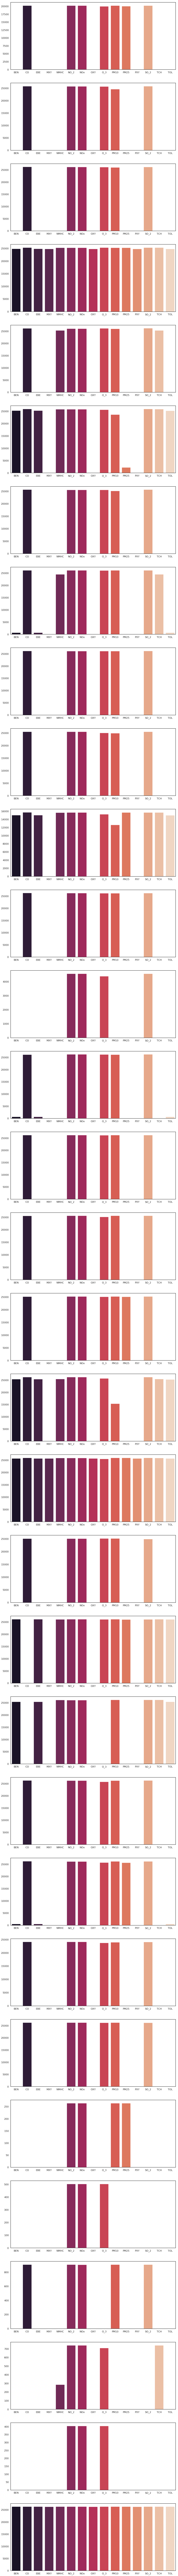

In [6]:
# initialize seaborn style
sns.set(style="white", context="talk")

i = 1

plt.figure(figsize=(20, 10*nb_stations))
# for each station
for station_name, station_data in stations:
    
    # get only the relevant data
    station_data = station_data.copy().drop(columns=['date', 'station'])
    
    # compute number of relevant measures
    column_set = np.empty(station_data.columns.shape)
    for idx, column in enumerate(station_data.columns):
        column_set[idx] = station_data.shape[0] - station_data[column].isna().sum()
    
    # display bar plot in a subfigure
    plt.subplot(nb_stations, 1, i)
    
    # update indice for the next subfigure
    i += 1
    sns.barplot(x=station_data.columns, y=column_set, palette="rocket")

## Analyser les mesures réalisées par la station 28079099

La station **28079099** est celle dont les relevés sont les plus complets. 

En récupérant les données de la station, un test rapide nous montre cependant qu'il reste quelques données manquantes.

In [7]:
# get station data
data_station = stations.get_group(28079099).copy()

# use date as index
data_station.set_index('date', inplace=True)

# sort data in chronological order
data_station.sort_index(inplace=True)

# display rows with missing data
data_station[data_station.isnull().any(axis=1)]

,BEN,CO,EBE,MXY,NMHC,NO_2,NOx,OXY,O_3,PM10,PM25,PXY,SO_2,TCH,TOL,station
date,,,,,,,,,,,,,,,,
2007-03-25 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28079099
2007-05-12 14:00:00,0.46,0.34,1.01,0.79,0.14,39.230000,55.590000,0.77,78.169998,7.490000,NaN,0.73,6.510000,1.30,2.550000,28079099
2007-08-05 17:00:00,0.68,0.17,0.79,1.72,0.16,25.600000,34.430000,0.82,55.500000,NaN,101.900002,0.93,6.190000,1.29,1.630000,28079099
2007-09-10 03:00:00,0.38,0.19,0.87,1.13,0.18,26.570000,29.879999,0.90,63.490002,NaN,37.860001,0.56,5.840000,1.39,2.100000,28079099
2008-01-10 01:00:00,1.34,0.55,1.76,NaN,0.31,66.209999,156.500000,NaN,6.370000,38.290001,24.480000,NaN,13.810000,1.54,9.730000,28079099
2008-01-10 02:00:00,1.31,0.50,2.07,NaN,0.33,59.770000,141.000000,NaN,6.710000,35.139999,21.660000,NaN,13.010000,1.61,12.140000,28079099
2008-01-10 03:00:00,1.24,0.45,2.12,NaN,0.35,54.779999,124.800003,NaN,7.050000,32.849998,20.360001,NaN,12.310000,1.74,11.020000,28079099
2008-01-10 04:00:00,1.40,0.43,2.50,NaN,0.38,50.580002,121.000000,NaN,7.030000,32.119999,19.950001,NaN,11.680000,1.97,16.719999,28079099
2008-01-10 05:00:00,1.18,0.38,1.93,NaN,0.35,44.169998,96.470001,NaN,6.940000,26.510000,17.379999,NaN,10.670000,1.95,12.160000,28079099


## Données journalières

Nous cherchons une strategie pour compléter les données manquantes. Nous pourrions par exemple ne pas travailler sur les relevés heure par heure, mais lisser ces relevés sur une journée. 

Pour savoir si nous n'allons pas perdre d'information importante,  regardons l'évolution des données sur une journée. Le fait que l'index de notre DataFrame soit la date de chaque relevé nous permet de sélectionner facilement les relevés réalisés entre le 1er juin 2008 et le 1er juiller 2008

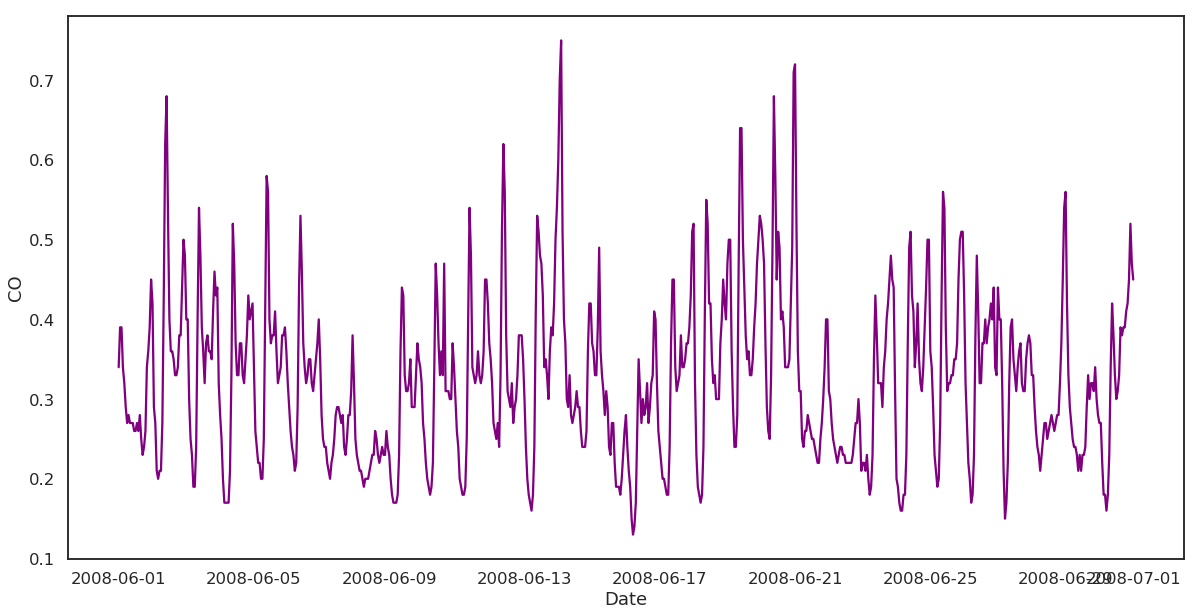

In [8]:
# get data
co_june_2008 = data_station.loc[pd.to_datetime('2008-06-01'):pd.to_datetime('2008-07-01')]['CO']

# display figure
plt.figure(figsize=(20, 10))
plt.plot(co_june_2008, c='purple')
plt.ylabel('CO')
plt.xlabel('Date')
plt.show()

Maintenant affichons le taux de monoxyde relevé sur tous les lundi du moins de juin. 

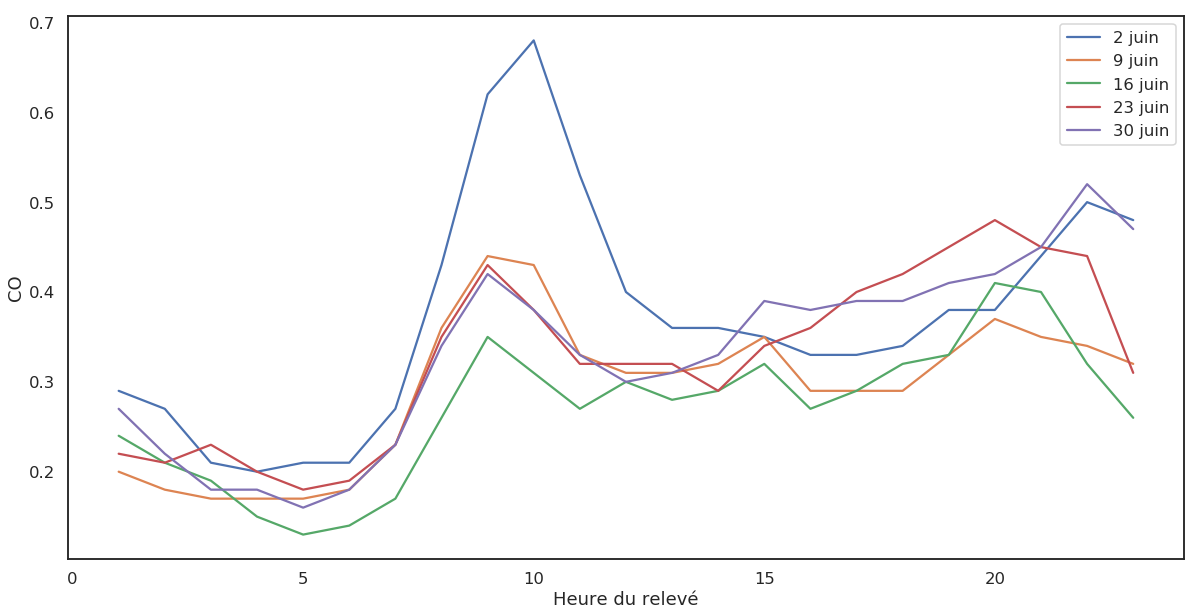

In [9]:
plt.figure(figsize=(20, 10))
for i in range(2, 31, 7):
    begin = '2008-06-{:02d} 01:00:00'.format(i)
    end  = '2008-06-{:02d} 23:00:00'.format(i)
    data_day= data_station.loc[pd.to_datetime(begin):pd.to_datetime(end)]['CO']
    plt.plot(data_day.index.hour, data_day, label=f'{i} juin')
    
plt.ylabel('CO')
plt.xlabel('Heure du relevé')
plt.legend()
plt.show()

Clairement, le taux de monoxyde n'est pas constant sur une journée. Il serait dommage de lisser les valeurs obtenues sur une journée.

## Données de synthèse

Une autre possibilité consiste à remplacer la donnée manquante par celle relevé au même moment l'année précédente ou l'année suivante. 

Pour déterminer si cette stratégie est pertinente, regardons comment évolue les moyennes annuelles.

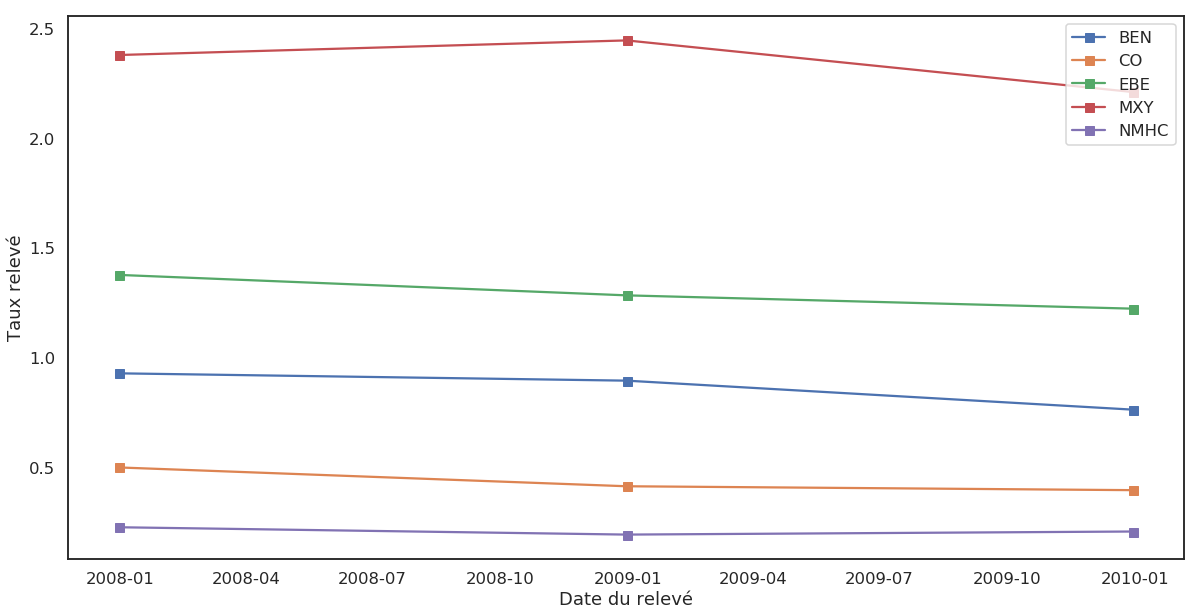

In [10]:
# Remove useless column, drop line with missing data and group remaning data by year
temp = data_station.drop(columns=['station']).dropna(axis=0).groupby(pd.Grouper(freq='Y')).mean()

# for each variable, display it's mean over one year
plt.figure(figsize=(20, 10))
for column in temp.columns[:5]:
    plt.plot(temp[column], label=column, marker='s')
    
plt.ylabel('Taux relevé')
plt.xlabel('Date du relevé')
plt.legend()
plt.show()
    

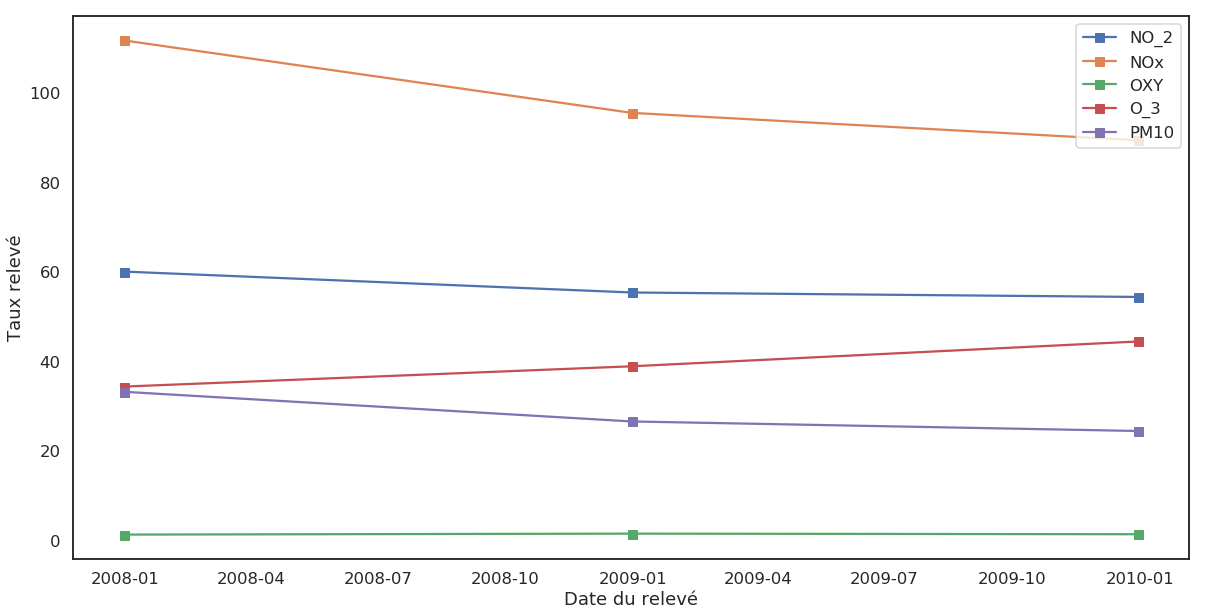

In [11]:
plt.figure(figsize=(20, 10))
for column in temp.columns[5:10]:    
    plt.plot(temp[column], label=column, marker='s')
    
plt.ylabel('Taux relevé')
plt.xlabel('Date du relevé')
plt.legend()
plt.show()

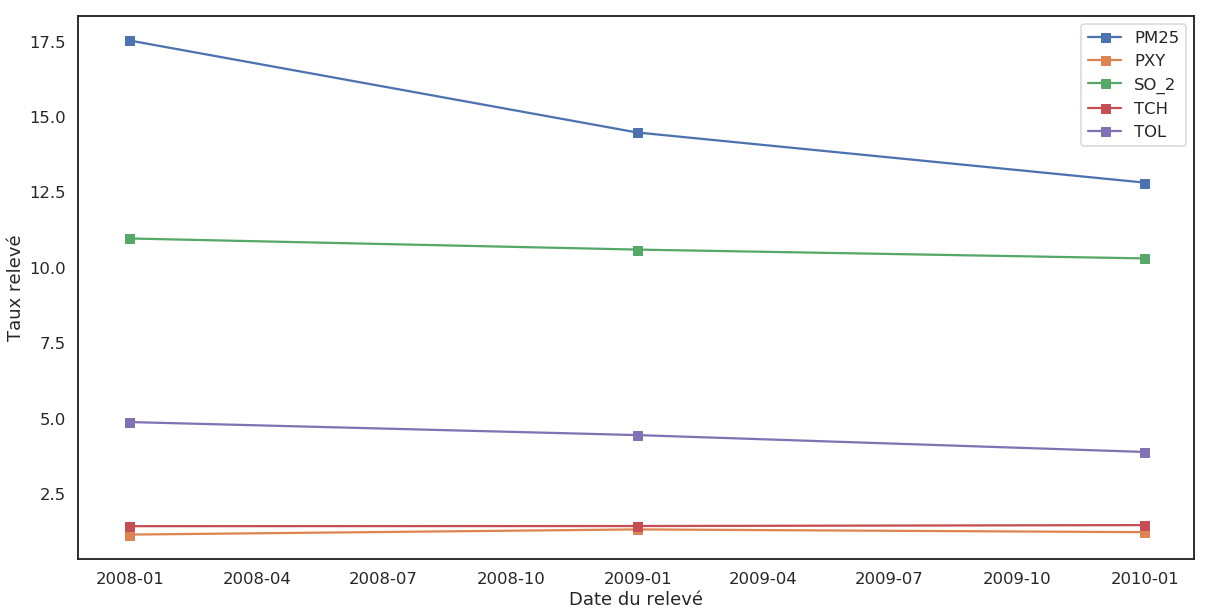

In [12]:
plt.figure(figsize=(20, 10))
for column in temp.columns[10:]:    
    plt.plot(temp[column], label=column, marker='s')
    
plt.ylabel('Taux relevé')
plt.xlabel('Date du relevé')
plt.legend()
plt.show()

Les moyennes annuelles pour certaines variables varient fortement. Pour ces variables il n'est pas recommandé de compléter une donnée manquante par une donnée relevée l'année précédente ou suivante.

## Interpolation

Finalement nous avons choisi d'interpoler les données manquantes à partir des données des heures précédentes et suivantes.

In [13]:
# remove useless column
data_station.drop(columns=['station'], inplace=True)

In [14]:
# use pandas interpolate function
data_station.interpolate(inplace=True)
# remove data for first and last days (some data are always missing)
data_station = data_station[pd.to_datetime('2007-02-02'):pd.to_datetime('2009-12-31 23:00:00')].copy()

In [15]:
# check there is no more missing data
dayly_group = data_station.groupby(pd.Grouper(freq='1D')).size()
incomplete_days_mask = dayly_group < 24
dayly_group[incomplete_days_mask]

Series([], Freq: D, dtype: int64)

# Prédictions du taux de monoxyde de carbone par un algorithme de Machine Learning

Maintenant que nos données sont complètes, nous allons les utiliser pour entraîner un algorithme de Machine Learning. Tout d'abord nous allons commencer par extraire des descripteurs. 

## Extraire les descripteurs

Un descripteur est un ensemble d'information donné à l'algorithme pour qu'il puisse réaliser une prédiction. Dans notre cas il s'agit des données relevées sur 48 heures. Ces données vont nous permettre de prédire le taux de monoxyde de la 49eme heure.

In [16]:
# create numpy array to store descriptors
nb_hours = 48
nb_releves = data_station.shape[0] - nb_hours
nb_measures = data_station.shape[1]
X = np.empty((nb_releves, nb_measures, nb_hours))
# store data
for i in range(nb_hours):
    X[:,:,i] = data_station.iloc[i:nb_releves+i]
X.shape

(25488, 15, 48)

## Extraire la vérité terrain
La vérité terrain correspond au taux de monoxyde effectivement relevé sur 49eme heure. Cette valeur va servir d'exemple à l'algorithme et lui permettre de s'entraîner à produire une prédiction pertinente à partir du descripteur.

In [17]:
Y = data_station.CO.values[nb_hours:nb_hours+nb_releves]
Y.shape

(25488,)

## Préparer les données pour un algorithme de machine learning standard


In [18]:
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import autosklearn.regression
from sklearn.preprocessing import MinMaxScaler
import pickle

Contrairement aux réseaux de neurones, les algorihtmes de machine learning classique (SVM, Random Forest, etc.) utilisent des descripteurs sous forme de vecteur à une dimension. Il nous faut donc modifier la structure du descripteur

In [19]:
X_autosk = X.reshape(nb_releves, nb_measures*nb_hours)

### Données d'apprentissage et de test

Nous allons ensuite séparer nos données en deux ensembles : l'un pour l'apprentissage de notre algorithme, l'autre pour vérifier que cet apprentissage a été bénéfique (les données de test).

Les données de tests doivent correspondent à 1/3 des données. Elles permettent entre autre de s'assurer que l'algorithme n'a pas sur-appris *i.e* qu'il ne s'est pas trop spécialisé sur les données d'apprentissages en perdant sa capacité à généraliser. 

Dans le cas de données temporelles, il est préférable que les données de tests soient postérieurs aux données d'apprentissage. Ainsi nous montrons qu'en entraînant l'algorithme sur les premiers relevés, nous pourrons prédire les taux de monoxydes futurs.

In [20]:
nb_train = int(nb_releves * 0.70)
X_train, X_test = X_autosk[:nb_train,:], X_autosk[nb_train:,:]
Y_train, Y_test = Y[:nb_train], Y[nb_train:]

### Normaliser les données

Derrière un algorithme de Machine Learning il y a toujours des calculs mathématiques. Pour éviter que ces derniers ne manipulent des valeurs trop grande, nous allons normaliser nos données

In [21]:
scaler = MinMaxScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

## Prédictions

Nous allons maintenant entraîner deux algorithmes différents :

* [AutoSklearn](https://automl.github.io/auto-sklearn/stable/) qui entraîne et combine plusieurs algorithmes de Machine Learning standard ;
* un réseau de Neurone très simple utilisant des couches de type [LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

### Entrainement avec autosklearn

**Attention :** l'entraînement de cette méthode peut prendre du temps (une heure, voir un peu plus). 

In [22]:
automl = autosklearn.regression.AutoSklearnRegressor()
automl.fit(scaled_X_train, Y_train)
automl.show_models()

/home/berengere/anaconda3/envs/tutorial_ml_env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)


[WARNING] [2019-01-18 15:59:55,433:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 15:59:55,444:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 15:59:55,549:AutoMLSMBO(1)::00a03cafb8ce959aed0a864c6506256a] Could not find meta-data directory /home/berengere/anaconda3/envs/tutorial_ml_env/lib/python3.6/site-packages/autosklearn/metalearning/files/r2_regression_dense
[WARNING] [2019-01-18 15:59:57,449:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 15:59:59,456:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:00:01,460:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:00:03,464:EnsembleBuilder(1):00a03cafb8c

[WARNING] [2019-01-18 16:01:49,746:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:01:51,750:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:01:53,754:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:01:55,758:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:01:57,762:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:01:59,765:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:02:01,773:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:02:03,777

[WARNING] [2019-01-18 16:03:50,029:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:03:52,033:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:03:54,037:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:03:56,040:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:03:58,044:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:04:00,047:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:04:02,051:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:04:04,055

[WARNING] [2019-01-18 16:05:50,296:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:05:52,301:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:05:54,304:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:05:56,308:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:05:58,314:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:06:00,318:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:06:02,322:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:06:04,326

[WARNING] [2019-01-18 16:07:50,582:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:07:52,586:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:07:54,588:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:07:56,592:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:07:58,596:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:08:00,600:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:08:02,605:EnsembleBuilder(1):00a03cafb8ce959aed0a864c6506256a] No models better than random - using Dummy Score!
[WARNING] [2019-01-18 16:08:04,609

/home/berengere/anaconda3/envs/tutorial_ml_env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/berengere/anaconda3/envs/tutorial_ml_env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/berengere/anaconda3/envs/tutorial_ml_env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/berengere/anaconda3/envs/tutorial_ml_env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of empty slice
  Y_train_pred = np.nanmean(Y_train_pred_full, axis=0)
/home/berengere/anaconda3/envs/tutorial_ml_env/lib/python3.6/site-packages/autosklearn/evaluation/train_evaluator.py:197: RuntimeWarning: Mean of em

"[(0.880000, SimpleRegressionPipeline({'categorical_encoding:__choice__': 'no_encoding', 'imputation:strategy': 'mean', 'preprocessor:__choice__': 'select_percentile_regression', 'regressor:__choice__': 'ridge_regression', 'rescaling:__choice__': 'minmax', 'preprocessor:select_percentile_regression:percentile': 45.45499333217325, 'preprocessor:select_percentile_regression:score_func': 'f_regression', 'regressor:ridge_regression:alpha': 2.1331281276474276e-05, 'regressor:ridge_regression:fit_intercept': 'True', 'regressor:ridge_regression:tol': 0.00016363573176907605},\ndataset_properties={\n  'task': 4,\n  'sparse': False,\n  'multilabel': False,\n  'multiclass': False,\n  'target_type': 'regression',\n  'signed': False})),\n(0.120000, SimpleRegressionPipeline({'categorical_encoding:__choice__': 'no_encoding', 'imputation:strategy': 'median', 'preprocessor:__choice__': 'select_percentile_regression', 'regressor:__choice__': 'extra_trees', 'rescaling:__choice__': 'minmax', 'preprocessor

### Évaluation

À l'aide du modèle entraîné nous réalisons des prédictions pour les données de test

In [23]:
Y_pred_autosklearn = automl.predict(scaled_X_test)

Le score R2 nous permet dévaluer la pertinence du résultat obtenu. Pour une étude plus poussé nous affichons également un diagramme de type boîte à moustache nous montrons la répartition des écarts entre la valeur prédite et la valeur effectivement mesurée.

R2 score: 0.9112976949670673


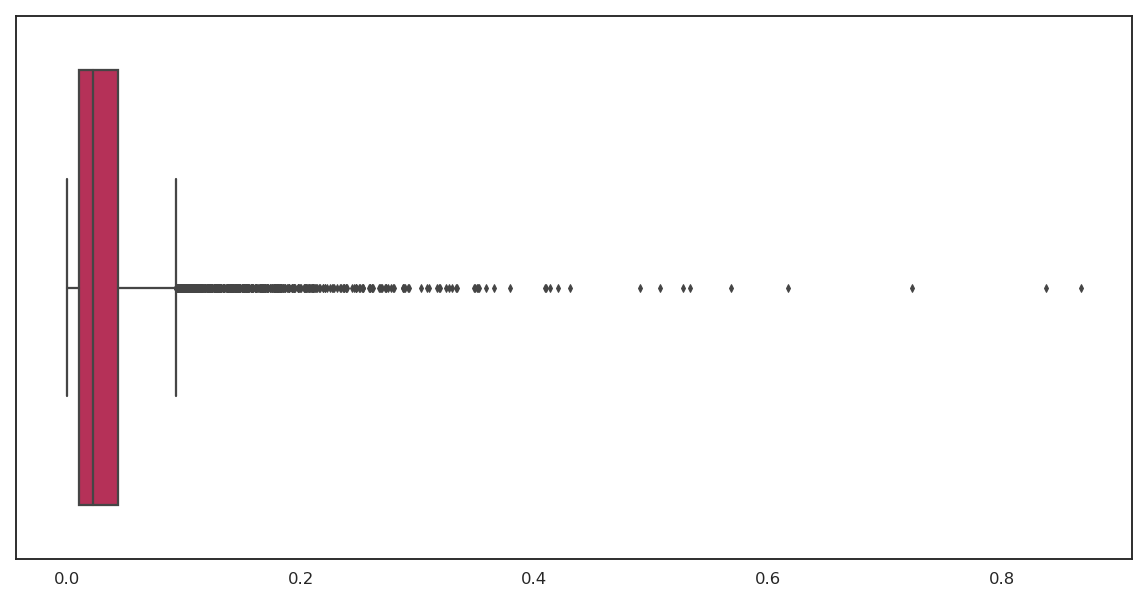

In [24]:
print("R2 score:", sklearn.metrics.r2_score(Y_test, Y_pred_autosklearn))
plt.figure(figsize=(20, 10))
sns.boxplot(np.abs(Y_test-Y_pred_autosklearn),  palette="rocket")
plt.show()

## Deep learning LSTM

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LSTM

Using TensorFlow backend.


### Créer le réseau de neurone

In [26]:
# création réseau
model = Sequential()
# ajouter une couche pour standardiser les données d'un batch
model.add(BatchNormalization(input_shape=(nb_measures, nb_hours)))
# ajouter des couches de type LSTM
model.add(LSTM(100, return_sequences=True, dropout=0.5))
model.add(LSTM(50, dropout=0.5))
# neurone de sortie
model.add(Dense(1))
# compiler le réseau
model.compile(loss='mean_squared_error', optimizer='adam')

Durant l'entraînement du réseau nous allons stocker les valeurs obtenus par la fonction de coût - la fonction qui permet au réseau de déterminer si sa prédiction est pertinente et de s'améliorer. Nous voulons vérifier que le coût, c'est à dire l'erreur produite par le réseau diminue bien au fil de l'apprentissage

In [27]:
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
history = LossHistory()

Le réseau va s'entraîner en parcourant plusieurs fois les descripteurs et la vérité terrain. Parcourir une fois la l'ensemble des données correspond à une **epoch**. Dans notre cas nous allons l'entraîner pendant **100 epochs**. 

In [28]:
model.fit(scaled_X_train.reshape((nb_train, nb_measures, nb_hours)), Y_train,
          epochs=100, batch_size=64, callbacks=[history])

Epoch 1/100
17841/17841 [==============================] - 26s 1ms/step - loss: 0.0469
Epoch 2/100
17841/17841 [==============================] - 20s 1ms/step - loss: 0.0325
Epoch 3/100
17841/17841 [==============================] - 21s 1ms/step - loss: 0.0279
Epoch 4/100
17841/17841 [==============================] - 21s 1ms/step - loss: 0.0248
Epoch 5/100
17841/17841 [==============================] - 20s 1ms/step - loss: 0.0226
Epoch 6/100
17841/17841 [==============================] - 21s 1ms/step - loss: 0.0218
Epoch 7/100
17841/17841 [==============================] - 20s 1ms/step - loss: 0.0197
Epoch 8/100
17841/17841 [==============================] - 18s 1ms/step - loss: 0.0188
Epoch 9/100
17841/17841 [==============================] - 21s 1ms/step - loss: 0.0166
Epoch 10/100
17841/17841 [==============================] - 20s 1ms/step - loss: 0.0164
Epoch 11/100
17841/17841 [==============================] - 19s 1ms/step - loss: 0.0154
Epoch 12/100
17841/17841 [===============

17841/17841 [==============================] - 19s 1ms/step - loss: 0.0058
Epoch 95/100
17841/17841 [==============================] - 19s 1ms/step - loss: 0.0057
Epoch 96/100
17841/17841 [==============================] - 20s 1ms/step - loss: 0.0062
Epoch 97/100
17841/17841 [==============================] - 23s 1ms/step - loss: 0.0063
Epoch 98/100
17841/17841 [==============================] - 20s 1ms/step - loss: 0.0060
Epoch 99/100
17841/17841 [==============================] - 19s 1ms/step - loss: 0.0055
Epoch 100/100
17841/17841 [==============================] - 19s 1ms/step - loss: 0.0058


Affichons les valeurs de coûts obtenus et vérifions que l'apprentissage c'est correctement passé.

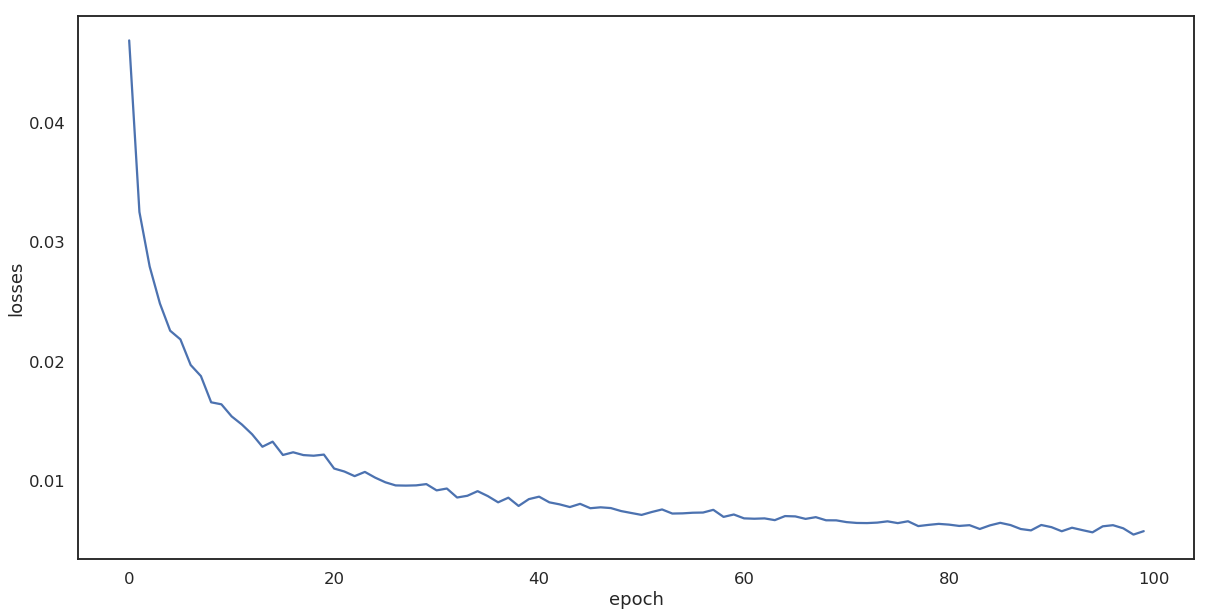

In [29]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(history.losses)), history.losses)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.show()

Sauvegardons le model.

In [30]:
model.save('data/lstm_model.h5')

Affichons le score R2 obtenu par le réseau

In [31]:
from keras.models import load_model
model = load_model('data/lstm_model.h5')
Y_pred = model.predict(scaled_X_test.reshape((nb_releves - nb_train, nb_measures, nb_hours)))
print("R2 score:", sklearn.metrics.r2_score(Y_test, Y_pred))

R2 score: 0.8491935644824573


Plutôt que d'afficher juste la boîte à moustache pour les écarts entre la prédiction et la vérité terrain du réseau, nous allons également afficher la boîte à moustache pour Sk-Learn, la méthode concurente.

In [38]:

diff_lstm =  np.abs(Y_test-Y_pred[:,0])
diff_askl = np.abs(Y_test-Y_pred_autosklearn)

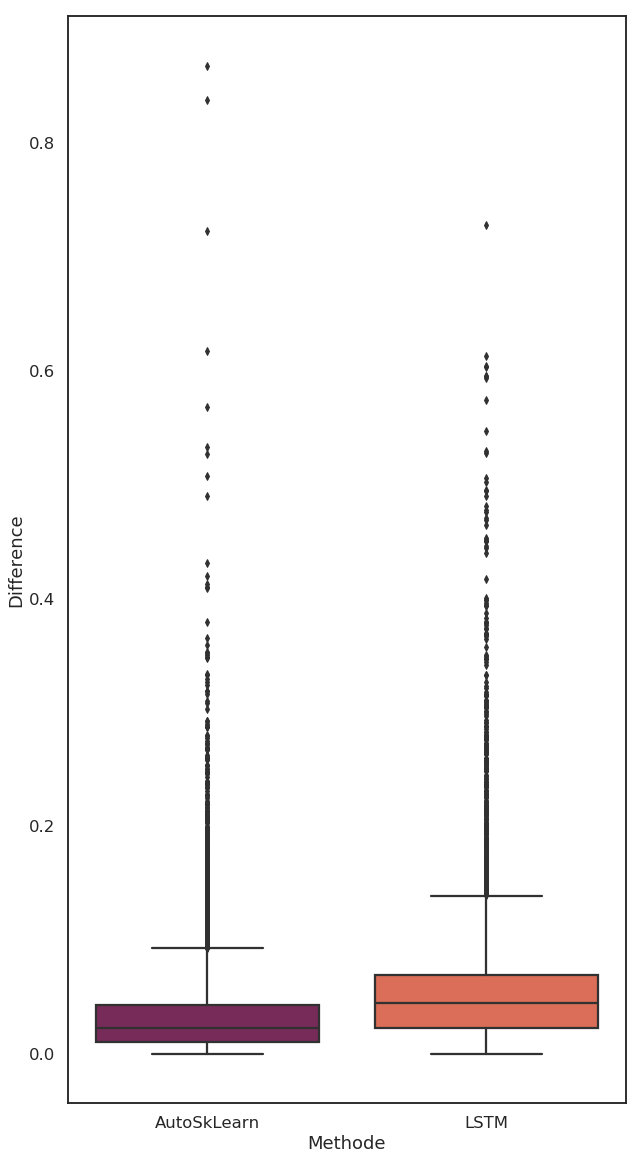

In [39]:


df1 = pd.DataFrame(data={'Difference':diff_askl, 'Methode': ['AutoSkLearn']*diff_askl.shape[0]})
df2 = pd.DataFrame(data={'Difference':diff_lstm, 'Methode':['LSTM']*diff_lstm.shape[0]})
df = pd.concat([df1, df2])
plt.figure(figsize=(10, 20))
sns.boxplot( x=df["Methode"], y=df["Difference"],  palette="rocket" )
plt.show()

Enfin affichons sur un diagramme l'évolution du taux de monoxide prédit et celle du taux de monoxyde effectivement mesuré (sur les données de tests). 

In [40]:
date_y =  data_station.index[nb_hours:nb_hours+nb_releves]
date_test = date_y[Y_train.shape[0]:]

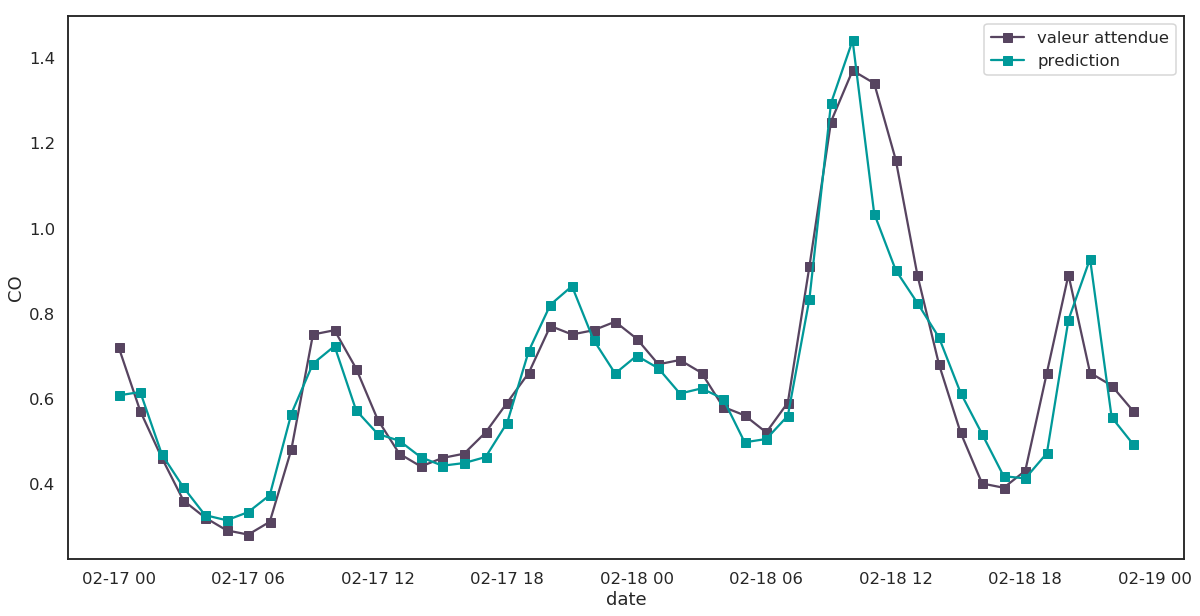

In [42]:
plt.figure(figsize=(20, 10))
makina_palette = ["#574460", "#009999"]
sns.set_palette(makina_palette)
i_begin = 15
i_end = i_begin + 48
plt.plot(date_test[i_begin:i_end], Y_test[i_begin:i_end], marker='s', label='valeur attendue')
plt.plot(date_test[i_begin:i_end], Y_pred[i_begin:i_end], marker='s', label='prediction')
plt.legend()
plt.xlabel('date')
plt.ylabel('CO')
plt.show()